In [1]:
#load the %autoreload extension using the %load_ext magic command
#Then, we set the %autoreload magic command to 2, which means that modules will be reloaded every time a cell is executed
%load_ext autoreload
%autoreload 2

### Method agnostic data preprocessing

In [2]:
DATASET_NAME = 'mirna_fcs'
MIRNA_NAME = 'hsa-miR-106b-5p'
# hsa-let-7c-5p
# hsa-miR-16-5p
MIRNA_SEQ = 'TAAAGTGCTGACAGTGCAGAT'

RANDOM_STATE = 42

In [173]:
from data_manipulation import download_data_from_github_if_not_existing

download_data_from_github_if_not_existing(
    url = "https://raw.githubusercontent.com/ML-Bioinfo-CEITEC/miRNA/main/modules/evaluation/mirna_fcs.csv",
    output_file_path = 'data/{}.csv'.format(DATASET_NAME),
)

'data/mirna_fcs.csv'

In [4]:
from data_manipulation import split_train_and_test_set


split_train_and_test_set(
    input_dataset_file_path = 'data/{}.csv'.format(DATASET_NAME),
    column_to_split = MIRNA_NAME,
    columns_to_keep = ['gene_symbol', MIRNA_NAME],
    test_fraction = 0.25, 
    random_state = RANDOM_STATE,
    splits_distributions_similarity_pvalue_threshold = 0.05,
    output_file_path_train = 'data/{}.{}.train.csv'.format(DATASET_NAME, MIRNA_NAME),
    output_file_path_test = 'data/{}.{}.test.csv'.format(DATASET_NAME, MIRNA_NAME),
)

('data/mirna_fcs.hsa-miR-106b-5p.train.csv',
 'data/mirna_fcs.hsa-miR-106b-5p.test.csv')

In [118]:
from data_manipulation import possitive_fold_change_to_zero


possitive_fold_change_to_zero(
    input_dataset_file_path = 'data/{}.{}.train.csv'.format(DATASET_NAME, MIRNA_NAME),
    column_name = MIRNA_NAME,
    output_path_suffix = '.positive_fc_to_zero',
)
possitive_fold_change_to_zero(
    input_dataset_file_path = 'data/{}.{}.test.csv'.format(DATASET_NAME, MIRNA_NAME),
    column_name = MIRNA_NAME,
    output_path_suffix = '.positive_fc_to_zero',
)

'data/mirna_fcs.hsa-miR-106b-5p.test.positive_fc_to_zero.csv'

### Data preprocessing specific for signal data (in the clean code, will be under a specific module)

In [119]:
import pandas as pd

from google_drive_download import download_file_from_google_drive

# TODO check if response OK
# TODO DOWNLOAD only if not exist
# download_file_from_google_drive(  
#     file_id = '1ayyD1w6SHzLS8638eoBzUX3OMq4cxSUx',
#     destination = 'data/explainability_scores_hsa-miR-106b-5p.json',
# )

In [120]:
from data_manipulation import convert_signals_json_to_pickle

convert_signals_json_to_pickle(
    signals_json_file_path = "data/explainability_scores_{}.json".format(MIRNA_NAME),
    output_file_path = "data/explainability_scores_{}.pkl".format(MIRNA_NAME),
    mirna_name = MIRNA_NAME,
    mirna_seq = MIRNA_SEQ,
)

'data/explainability_scores_hsa-miR-106b-5p.pkl'

In [123]:
from data_manipulation import merge_fold_change_dataset_with_signals

merge_fold_change_dataset_with_signals(
    signals_df_path = 'data/explainability_scores_{}.pkl'.format(MIRNA_NAME),
    fold_change_df_path = 'data/{}.{}.train.positive_fc_to_zero.csv'.format(DATASET_NAME, MIRNA_NAME),
    merge_on = 'gene_symbol',
    mirna_name = MIRNA_NAME,
    # output_path_suffix = '.signals',
    output_file_path = 'data/{}.{}.train.positive_fc_to_zero.signals.pkl'.format(DATASET_NAME, MIRNA_NAME),
)
merge_fold_change_dataset_with_signals(
    signals_df_path = 'data/explainability_scores_{}.pkl'.format(MIRNA_NAME),
    fold_change_df_path = 'data/{}.{}.test.positive_fc_to_zero.csv'.format(DATASET_NAME, MIRNA_NAME),
    merge_on = 'gene_symbol',
    mirna_name = MIRNA_NAME,
    # output_path_suffix = '.signals',
    output_file_path = 'data/{}.{}.test.positive_fc_to_zero.signals.pkl'.format(DATASET_NAME, MIRNA_NAME),
)

'data/mirna_fcs.hsa-miR-106b-5p.test.positive_fc_to_zero.signals.pkl'

In [132]:
from data_manipulation import compress_signal_zeros_in_dataset

compress_signal_zeros_in_dataset(
    input_dataset_file_path = 'data/{}.{}.train.positive_fc_to_zero.signals.pkl'.format(DATASET_NAME, MIRNA_NAME),
    output_path_suffix = '.compressed_zeros',
)    
compress_signal_zeros_in_dataset(
    input_dataset_file_path = 'data/{}.{}.test.positive_fc_to_zero.signals.pkl'.format(DATASET_NAME, MIRNA_NAME),
    output_path_suffix = '.compressed_zeros',
)

'data/mirna_fcs.hsa-miR-106b-5p.test.positive_fc_to_zero.signals.compressed_zeros.pkl'

In [150]:
# remove [] and NaN from train, cos we do not want to teach the model that *no binding site* means negative fold change
# that is basically propagation of error from previous model
# in test we predict 0 FC for such a sample without signal (which might be incorrect prediction, but it is the approach for now)
# [] means miRbind predicted 0 binding sites
# NaN means we are completely missing prediction for that gene == the gene is not in our miRBind set for scanning 
from data_manipulation import remove_genes_with_no_binding_sites

remove_genes_without_signal(
    input_dataset_file_path_train = 'data/{}.{}.train.positive_fc_to_zero.signals.compressed_zeros.pkl'.format(DATASET_NAME, MIRNA_NAME),
    output_path_suffix = '.remove_genes_without_signal',
)

'data/mirna_fcs.hsa-miR-106b-5p.train.positive_fc_to_zero.signals.compressed_zeros.remove_not_predicted.pkl'

In [127]:
from data_manipulation import predict_genes_without_signal_as_zeros

predict_genes_without_signal_as_zeros(
    input_file_path = 'data/{}.{}.test.positive_fc_to_zero.signals.compressed_zeros.pkl'.format(DATASET_NAME, MIRNA_NAME),
    prediction_column_name = 'prediction',
    output_path_suffix = ".predict_genes_without_signal",
)

'data/mirna_fcs.hsa-miR-106b-5p.test.positive_fc_to_zero.signals.compressed_zeros.predict_genes_without_signal.pkl'

### Method specific data preprocessing (in the clean code, will be under a specific method module)

In [190]:
from data_manipulation import apply_map_function_to_column, zeros_to_negative

apply_map_function_to_column(
    map_function = zeros_to_negative,
    input_file_path = 'data/{}.{}.train.positive_fc_to_zero.signals.compressed_zeros.remove_genes_without_signal.pkl'.format(DATASET_NAME, MIRNA_NAME),
    column_name = "signal",
    output_path_suffix = ".zero_signal_to_negative",
)

'data/mirna_fcs.hsa-miR-106b-5p.train.positive_fc_to_zero.signals.compressed_zeros.remove_genes_without_signal.zero_signal_to_negative.pkl'

In [191]:
from data_manipulation import apply_map_function_to_column, zeros_to_negative

apply_map_function_to_column(
    map_function = zeros_to_negative,
    input_file_path = 'data/{}.{}.test.positive_fc_to_zero.signals.compressed_zeros.predict_genes_without_signal.pkl'.format(DATASET_NAME, MIRNA_NAME),
    column_name = "signal",
    output_path_suffix = ".zero_signal_to_negative",
)

'data/mirna_fcs.hsa-miR-106b-5p.test.positive_fc_to_zero.signals.compressed_zeros.predict_genes_without_signal.zero_signal_to_negative.pkl'

In [192]:
from data_manipulation import normalize_column_based_on_train_set

normalize_column_based_on_train_set(
    input_file_path_train = 'data/{}.{}.train.positive_fc_to_zero.signals.compressed_zeros.remove_genes_without_signal.zero_signal_to_negative.pkl'.format(DATASET_NAME, MIRNA_NAME),
    input_file_path_test = 'data/{}.{}.test.positive_fc_to_zero.signals.compressed_zeros.predict_genes_without_signal.zero_signal_to_negative.pkl'.format(DATASET_NAME, MIRNA_NAME),
    column = 'signal',
    output_path_suffix = ".normalize",
)

('data/mirna_fcs.hsa-miR-106b-5p.train.positive_fc_to_zero.signals.compressed_zeros.remove_genes_without_signal.zero_signal_to_negative.normalize.pkl',
 'data/mirna_fcs.hsa-miR-106b-5p.test.positive_fc_to_zero.signals.compressed_zeros.predict_genes_without_signal.zero_signal_to_negative.normalize.pkl')

In [195]:
from data_manipulation import apply_map_function_to_column, fill_empty_signal

apply_map_function_to_column(
    map_function = fill_empty_signal,
    input_file_path = 'data/{}.{}.test.positive_fc_to_zero.signals.compressed_zeros.predict_genes_without_signal.zero_signal_to_negative.normalize.pkl'.format(DATASET_NAME, MIRNA_NAME),
    column_name = "signal",
    output_path_suffix = ".fill_empty_signal"
)

'data/mirna_fcs.hsa-miR-106b-5p.test.positive_fc_to_zero.signals.compressed_zeros.predict_genes_without_signal.zero_signal_to_negative.normalize.fill_empty_signal.pkl'

### Model training (in the clean code, will be under a specific module)

In [ ]:
download_data_from_github_if_not_existing(
    url = "https://raw.githubusercontent.com/ML-Bioinfo-CEITEC/miRNA/main/modules/evaluation/mirna_fcs.csv",
    output_file_path = 'data/{}.csv'.format(DATASET_NAME),
)

In [123]:
EXPERIMENT_NAME = 'cnn_att'
DATASET_NAME = 'mirna_fcs'
MIRNA_NAME = 'hsa-miR-106b-5p'

RANDOM_STATE = 42
BATCH_SIZE = 32


In [4]:
from pytorch_lightning.loggers import CometLogger

comet_logger = CometLogger(
    api_key="EpKIINrla6U4B4LJhd9Sv4i0b",
    project_name="mirna",
)

CometLogger will be initialized in online mode


In [5]:
import pandas as pd

input_dataset_file_path_train = 'data/{}.{}.train.positive_fc_to_zero.signals.compressed_zeros.remove_genes_without_signal.zero_signal_to_negative.normalize.pkl'.format(DATASET_NAME, MIRNA_NAME),
df_train = pd.read_pickle(input_dataset_file_path_train)

input_dataset_file_path_test = 'data/{}.{}.test.positive_fc_to_zero.signals.compressed_zeros.predict_genes_without_signal.zero_signal_to_negative.normalize.fill_empty_signal.pkl'.format(DATASET_NAME, MIRNA_NAME),
df_test = pd.read_pickle(input_dataset_file_path_test)

In [8]:
def pad_2d_array_to_longest_subarray_length(arr, pad_value=0):
    # Find the maximum length of sublists
    max_len = max(len(sublist) for sublist in arr)
    
    # Pad the sublists to max length
    padded_arr = [sublist + [pad_value] * (max_len - len(sublist)) for sublist in arr]
    
    return padded_arr

In [13]:
df_train['signal'] = pad_2d_array_to_longest_subarray_length(df_train['signal'])
df_test['signal'] = pad_2d_array_to_longest_subarray_length(df_test['signal'])

In [16]:
from sklearn.model_selection import train_test_split

#split validation set
df_train, df_val = train_test_split(
    df_train, 
    test_size = 0.1, 
    random_state = RANDOM_STATE,
    shuffle=True
)

In [35]:
print(
    df_train['gene_symbol'].size, 
    df_test['gene_symbol'].size,
    df_val['gene_symbol'].size,
)

3582 2023 399


In [17]:
from dataset import get_train_dataloader, get_val_dataloader, get_test_dataloader
import torch

train_loader = get_train_dataloader([torch.tensor(x) for x in df_train['signal']], df_train['fold_change'].values, BATCH_SIZE)
val_loader = get_val_dataloader([torch.tensor(x) for x in df_val['signal']], df_val['fold_change'].values, BATCH_SIZE)
test_loader = get_test_dataloader([torch.tensor(x) for x in df_test['signal']], df_test['fold_change'].values, BATCH_SIZE)

In [127]:
from model import Small_CNN

from pytorch_lightning import Trainer
from IPython.utils import io


model = Small_CNN(
    pooling='att',
    # pooling='max',
    # pooling='rnn',
    lr=1e-3,
    warmup_steps=1,
    wd=0.01,
    logging_steps=1,
    pos_weight=1.0,
    num_cnn_layers=4,
)
# trainer = Trainer(max_epochs=1, gpus=1)  # Use GPU if available
trainer = Trainer(logger=comet_logger, max_epochs=50)  

# capture_output to have a cleaner notebook
# you can follow the training at the  https://www.comet.com/davidcechak/mirna/  see log of this cell
with io.capture_output() as captured:
    trainer.fit(model, train_loader, val_loader)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params
---------------------------------------------------
0 | architecture | Sequential        | 13.0 K
1 | ce           | MSELoss           | 0     
2 | mae          | MeanAbsoluteError | 0     
3 | mse          | MeanSquaredError  | 0     
4 | r2           | R2Score           | 0     
---------------------------------------------------
13.0 K    Trainable params
0         Non-trainable params
13.0 K    Total params
0.052     Total estimated model params size (MB)
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.c

In [128]:
from dataset import predict

gene_to_predictions, predictions = predict(model, [torch.tensor(x) for x in df_test['signal']], df_test['gene_symbol'].values)

In [129]:
from utils import get_experiment_time_id

experiment_id = get_experiment_time_id(sufix=EXPERIMENT_NAME)
experiment_id

'07-11-23_23-20.cnn_att'

In [139]:
from data_manipulation import add_predictions_to_test_dataframe

method_predictions, results_file_path = add_predictions_to_test_dataframe(
    df_test,
    gene_to_predictions,
    output_file_path = 'results/{}.{}.test.positive_fc_to_zero.signals.compressed_zeros.predict_genes_without_signal.zero_signal_to_negative.normalize.fill_empty_signal.{}.pkl'.format(
        DATASET_NAME,
        MIRNA_NAME,
        experiment_id,
    )
)

In [145]:
method_predictions[['fold_change', 'prediction']].corr()

,fold_change,prediction
fold_change,1.000000,0.081017
prediction,0.081017,1.000000


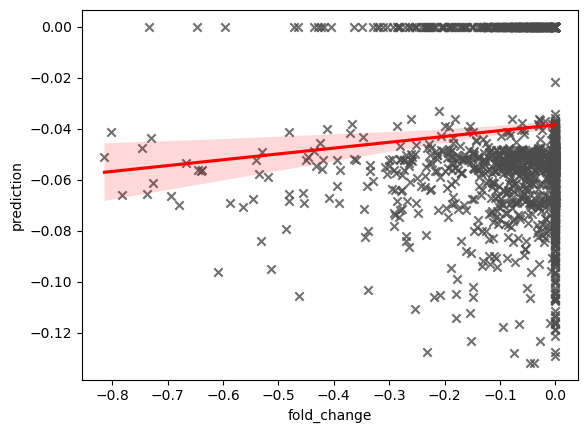

In [155]:
import seaborn as sns

sns.regplot(
    data=method_predictions[['fold_change', 'prediction']], 
    x="fold_change",
    y="prediction", 
    ci=99, marker="x", color=".3", line_kws=dict(color="r"),
)